In [1]:
import os
import numpy as np
import pandas as pd
import nltk
import keras
import six
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,AveragePooling1D,Flatten,concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/roberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/roberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
#Abro el archivo en el que se encuentra el dataset de los problemas
with open('singleop.json', 'r') as f:
    datastore = json.load(f)

In [4]:
# Archivo que contiene un listado de nombres
nombres = pd.read_csv('nombres-2015.csv')
names = pd.read_csv('yob2019.txt', header=None)    

In [5]:
dataset2 = pd.read_csv('problemas_adicionales2.csv')

In [6]:
preguntas = []
respuestas = []
ecuaciones = []
alineacion = []

for item in datastore:
    preguntas.append(item['sQuestion'])
    respuestas.append(item['lSolutions'])
    ecuaciones.append(item['lEquations'])
    alineacion.append(item['lAlignments'])

In [7]:
# Necesito convertir el dataset en un problema de clasificacion para que la red neuronal pueda identificar
# si estoy tratando de resolver un problema de sumas, restas, multiplicaciones o divisiones.
# Esto va a crear una lista con el tipo de operacion y que va a ser el resultado a inferir.
operaciones = []
sumas =0
restas =0
multiplicaciones =0
divisiones = 0
otras = 0
#Clasifico las operaciones en 0 para sumas, 1 para restas, 2 para multiplicaciones, 3 para divisiones y 4 sino lo encuentro.
for operacion in ecuaciones:
    if (operacion[0].find('+')>=0):
        operaciones.append(0)
        sumas = sumas + 1
    elif (operacion[0].find('-') >= 0 ):
        operaciones.append(1)
        restas = restas + 1
    elif(operacion[0].find('*') >=0):
        operaciones.append(2)
        multiplicaciones = multiplicaciones + 1
    elif(operacion[0].find('/')):
        operaciones.append(3)
        divisiones = divisiones + 1
    else:
        operaciones.append(4)
        otras = otras + 1

print('Tengo ', sumas, ' sumas ', restas, ' restas, ', multiplicaciones, ' multiplicaciones, ', divisiones, ' divisiones y otras operaciones ', otras)

Tengo  159  sumas  162  restas,  117  multiplicaciones,  124  divisiones y otras operaciones  0


In [8]:
preguntas2 = dataset2['Preguntas'].tolist()
respuestas2 = dataset2['respuestas'].tolist()

In [9]:
preguntas3 = preguntas + preguntas2
respuestas3 = operaciones + respuestas2

In [10]:
#El listado de nombres lo voy a truncar a los 15K primeros, dado que el resto son nombres muy residuales.
nombres_ = nombres['nombre'][:15000]

In [11]:
names_= names[0]

In [12]:
nombres_ = nombres_.append(names_)

In [13]:
st_words = list(stop_words)

In [14]:
nom = nombres['nombre'].values.tolist()

In [15]:
nomb =  nom + st_words

In [16]:
nomb[-1]

'haya'

In [17]:
# El vector preguntas_sin, consiste en las preguntas a las que voy a eliminar todos los nombres propios que no
# anaden ningun valor al conjunto de preguntas. No quiero que esos nombres se procesen y por tanto los elimino.
def eliminar_palabras(dataset, stopw):
    preguntas_sin = []
    for palabras in dataset:
        frases = [word for word in palabras.split(' ') if word not in stopw]
        frases = " ".join(frases)
        preguntas_sin.append(frases)
    return preguntas_sin

In [18]:
preguntas_sin = preguntas3 + eliminar_palabras(preguntas3, nom) + eliminar_palabras(preguntas3, st_words)

In [19]:
respuestas3 = respuestas3 * 3

In [20]:
from sklearn.utils import shuffle

preguntas3, respuestas3 = shuffle(preguntas_sin,respuestas3)

In [21]:
frases = []
palabra_sola = []
tokenizer = RegexpTokenizer(r'\w+')

for i,pregunta in enumerate(preguntas_sin):
    palabras = tokenizer.tokenize(pregunta)
    preguntas_w = []
    for j, palabra in enumerate(reversed(palabras)):
        preguntas_w.append(palabra)
        palabra_sola.append(palabra)
        if(j == 10):
            continue
    frases.append(preguntas_w)

In [22]:
palabras_unicas = set(palabra_sola)

In [23]:
len(palabras_unicas)

2522

In [24]:
p_unicas = list(palabras_unicas)

#Voy a convertir los indices a escala logaritmica para evitar que puedan reventar los pesos en la red neuronal
vocabulario = {p:i for i, p in enumerate(p_unicas)}

In [25]:
tamanoMedio = 0
tamanoTotal = 0

for pregunta in frases:
    if(len(pregunta) > tamanoTotal):
        tamanoTotal = len(pregunta)
    tamanoMedio = tamanoMedio + len(pregunta)

print("El tamano max es ", tamanoTotal, " y la media de la longitud de las frases es de", tamanoMedio/len(frases))

El tamano max es  49  y la media de la longitud de las frases es de 17.141341546885695


In [26]:
# Voy a meter en este vector todas mis preguntas y todas las palabras.
# Para esta prueba, vamos a poner en la posición de la frase, el número de la palabra que estamos procesando.
# El objetivo es procesar las palabras teniendo en cuenta el orden secuencial de la frase.
bag = np.zeros([len(frases), tamanoTotal, len(palabras_unicas)])

In [27]:
bag.shape

(2922, 49, 2522)

In [28]:
for i, pregunta in enumerate(frases):
    for j, palabras in enumerate(pregunta):
        bag[i, tamanoTotal - len(pregunta) + j, vocabulario[palabras]] = 1.0

In [29]:
bag[0][0]

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
training_X = np.asarray(bag[:1800])
test_X = np.asarray(bag[1800:])
training_y = np.asarray(respuestas3[:1800])
test_y = np.asarray(respuestas3[1800:])


In [39]:
# Creamos un modelo donde el primer argumento de la capa embedding son las palabras totales que voy a procesar
# vectorizadas en un indice.
# El segundo argumento, es el tamano del vector embedding, que he fijado en 16.
# El tercer argumento, es el tamano o longitud maxima, que he definido para las preguntas. Numero total de palabras
# por pregunta.
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(36, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation='softmax')
])

#model.compile(loss='sparse_categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',optimizer='RMSProp',metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [40]:
history = model.fit(training_X, training_y, epochs = 140, validation_data=(test_X, test_y), batch_size = 128)

Epoch 1/140
15/15 [==============================] - 3s 188ms/step - loss: 1.3636 - accuracy: 0.3556 - val_loss: 1.3525 - val_accuracy: 0.3752
Epoch 2/140
15/15 [==============================] - 2s 156ms/step - loss: 1.2843 - accuracy: 0.3717 - val_loss: 1.3488 - val_accuracy: 0.3752
Epoch 3/140
15/15 [==============================] - 2s 111ms/step - loss: 1.1855 - accuracy: 0.4261 - val_loss: 1.3617 - val_accuracy: 0.3601
Epoch 4/140
15/15 [==============================] - 2s 121ms/step - loss: 1.0586 - accuracy: 0.5600 - val_loss: 1.3913 - val_accuracy: 0.3476
Epoch 5/140
15/15 [==============================] - 2s 130ms/step - loss: 0.9132 - accuracy: 0.6839 - val_loss: 1.4376 - val_accuracy: 0.3191
Epoch 6/140
15/15 [==============================] - 2s 119ms/step - loss: 0.7850 - accuracy: 0.7350 - val_loss: 1.5033 - val_accuracy: 0.2807
Epoch 7/140
15/15 [==============================] - 2s 120ms/step - loss: 0.6774 - accuracy: 0.7550 - val_loss: 1.5818 - val_accuracy: 0.2656

Epoch 58/140
15/15 [==============================] - 3s 177ms/step - loss: 0.2879 - accuracy: 0.8017 - val_loss: 3.4393 - val_accuracy: 0.2567
Epoch 59/140
15/15 [==============================] - 2s 120ms/step - loss: 0.2916 - accuracy: 0.8028 - val_loss: 3.4533 - val_accuracy: 0.2540
Epoch 60/140
15/15 [==============================] - 2s 123ms/step - loss: 0.2897 - accuracy: 0.7889 - val_loss: 3.4920 - val_accuracy: 0.2594
Epoch 61/140
15/15 [==============================] - 2s 121ms/step - loss: 0.2876 - accuracy: 0.8011 - val_loss: 3.5493 - val_accuracy: 0.2709
Epoch 62/140
15/15 [==============================] - 2s 125ms/step - loss: 0.2845 - accuracy: 0.7972 - val_loss: 3.5750 - val_accuracy: 0.2683
Epoch 63/140
15/15 [==============================] - 2s 123ms/step - loss: 0.2866 - accuracy: 0.7956 - val_loss: 3.6091 - val_accuracy: 0.2647
Epoch 64/140
15/15 [==============================] - 2s 115ms/step - loss: 0.2869 - accuracy: 0.7944 - val_loss: 3.6527 - val_accuracy:

Epoch 115/140
15/15 [==============================] - 2s 147ms/step - loss: 0.2729 - accuracy: 0.8067 - val_loss: 4.7714 - val_accuracy: 0.2602
Epoch 116/140
15/15 [==============================] - 2s 117ms/step - loss: 0.2700 - accuracy: 0.8033 - val_loss: 4.7391 - val_accuracy: 0.2611
Epoch 117/140
15/15 [==============================] - 2s 128ms/step - loss: 0.2683 - accuracy: 0.8094 - val_loss: 4.7691 - val_accuracy: 0.2602
Epoch 118/140
15/15 [==============================] - 2s 126ms/step - loss: 0.2653 - accuracy: 0.8072 - val_loss: 4.7873 - val_accuracy: 0.2549
Epoch 119/140
15/15 [==============================] - 2s 139ms/step - loss: 0.2685 - accuracy: 0.8100 - val_loss: 4.8101 - val_accuracy: 0.2567
Epoch 120/140
15/15 [==============================] - 2s 123ms/step - loss: 0.2670 - accuracy: 0.8144 - val_loss: 4.8802 - val_accuracy: 0.2513
Epoch 121/140
15/15 [==============================] - 2s 114ms/step - loss: 0.2637 - accuracy: 0.8189 - val_loss: 4.9518 - val_ac

In [41]:
model2 = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(128, dropout = 0.2, input_shape=[len(vocabulario), bag.shape[1], bag.shape[2]])),
    keras.layers.Dense(4, activation='softmax')
])

opt = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#opt = keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
#opt = keras.optimizers.Adam(learning_rate = 0.0001)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [34]:
training_X.shape

(1800, 49, 2522)

In [42]:
history2 = model2.fit(training_X, training_y, epochs = 140, batch_size= 128, validation_data=(test_X, test_y))

Epoch 1/140
15/15 [==============================] - 35s 2s/step - loss: 1.3682 - accuracy: 0.3589 - val_loss: 1.3472 - val_accuracy: 0.3752
Epoch 2/140
15/15 [==============================] - 33s 2s/step - loss: 1.3247 - accuracy: 0.3711 - val_loss: 1.3454 - val_accuracy: 0.3752
Epoch 3/140
15/15 [==============================] - 32s 2s/step - loss: 1.3127 - accuracy: 0.3711 - val_loss: 1.3469 - val_accuracy: 0.3752
Epoch 4/140
15/15 [==============================] - 30s 2s/step - loss: 1.2933 - accuracy: 0.3950 - val_loss: 1.3546 - val_accuracy: 0.3610
Epoch 5/140
15/15 [==============================] - 34s 2s/step - loss: 1.2382 - accuracy: 0.4378 - val_loss: 2.9152 - val_accuracy: 0.2433
Epoch 6/140
15/15 [==============================] - 34s 2s/step - loss: 1.2671 - accuracy: 0.4928 - val_loss: 1.5216 - val_accuracy: 0.2594
Epoch 7/140
15/15 [==============================] - 37s 2s/step - loss: 1.1339 - accuracy: 0.5106 - val_loss: 1.7707 - val_accuracy: 0.3119
Epoch 8/140
1

Epoch 59/140
15/15 [==============================] - 34s 2s/step - loss: 0.5336 - accuracy: 0.7194 - val_loss: 4.2160 - val_accuracy: 0.2843
Epoch 60/140
15/15 [==============================] - 34s 2s/step - loss: 0.5529 - accuracy: 0.7072 - val_loss: 3.1451 - val_accuracy: 0.2843
Epoch 61/140
15/15 [==============================] - 34s 2s/step - loss: 0.5245 - accuracy: 0.7122 - val_loss: 3.3229 - val_accuracy: 0.2567
Epoch 62/140
15/15 [==============================] - 34s 2s/step - loss: 0.5327 - accuracy: 0.7111 - val_loss: 4.3398 - val_accuracy: 0.2799
Epoch 63/140
15/15 [==============================] - 33s 2s/step - loss: 0.5204 - accuracy: 0.7122 - val_loss: 3.4002 - val_accuracy: 0.2567
Epoch 64/140
15/15 [==============================] - 35s 2s/step - loss: 0.5239 - accuracy: 0.7211 - val_loss: 3.9195 - val_accuracy: 0.2692
Epoch 65/140
15/15 [==============================] - 39s 3s/step - loss: 0.5252 - accuracy: 0.7139 - val_loss: 4.2284 - val_accuracy: 0.2594
Epoch 

15/15 [==============================] - 29s 2s/step - loss: 0.4229 - accuracy: 0.7539 - val_loss: 4.3373 - val_accuracy: 0.2674
Epoch 117/140
15/15 [==============================] - 30s 2s/step - loss: 0.4243 - accuracy: 0.7717 - val_loss: 4.8749 - val_accuracy: 0.2602
Epoch 118/140
15/15 [==============================] - 29s 2s/step - loss: 0.4224 - accuracy: 0.7661 - val_loss: 4.9204 - val_accuracy: 0.2736
Epoch 119/140
15/15 [==============================] - 29s 2s/step - loss: 0.4219 - accuracy: 0.7650 - val_loss: 4.4136 - val_accuracy: 0.2487
Epoch 120/140
15/15 [==============================] - 29s 2s/step - loss: 0.4426 - accuracy: 0.7639 - val_loss: 4.6275 - val_accuracy: 0.2594
Epoch 121/140
15/15 [==============================] - 29s 2s/step - loss: 0.4068 - accuracy: 0.7722 - val_loss: 4.6191 - val_accuracy: 0.2647
Epoch 122/140
15/15 [==============================] - 30s 2s/step - loss: 0.4067 - accuracy: 0.7750 - val_loss: 4.9872 - val_accuracy: 0.2513
Epoch 123/140

In [43]:
import matplotlib.pyplot as plt

def resultados(history):
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

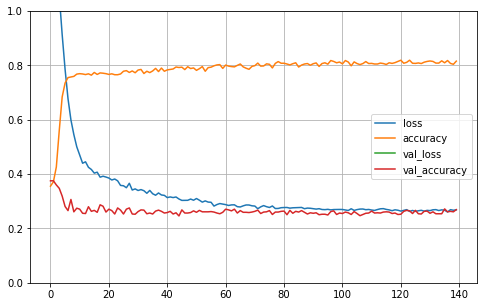

In [44]:
resultados(history)

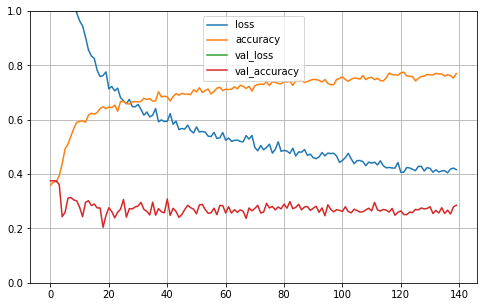

In [45]:
resultados(history2)